# Setgmentation of P.aeruginosa of different density

## Introduction

In part A of project 1, the goal is to perform segmentation of P.aeruginosa of different density. 

P.aeruginosa cells were imaged mainly with phase contrast microscopy. In each frame of the time stack image, we can see dark gray, rod-like cells with bright edges distribute across the field of view. 

An ideal segmentation should be able to identify the boundary of each cell, exclude the background, and assign each cell a unique label for later tracking. In this jupyter notebook, we will try to explore different segmentation methods, perform simple benchmarking, and select the best method for further analysis.

In [61]:
# import libraries
# for file handling
import os
import time
import scipy
# reading files under given folder
import glob
# progress bar
import tqdm
import numpy as np
# plotting
import matplotlib.pyplot as plt
# imaging processing
import skimage as ski
# data processing and manipulation
import pandas as pd
# misic deep learning segmentation
from misic.misic import *
from misic.utils import *
from misic.extras import *
# plotting settings
from IPython.display import clear_output
%matplotlib inline

ModuleNotFoundError: No module named 'cv2'

In [3]:
def crop_image(image, crop_width=500, crop_height=500):
    im_width = image.shape[2]
    im_height = image.shape[1]
    image_cropped = image[:, im_height//2-crop_height//2:im_height//2+crop_height//2, im_width//2-crop_width//2:im_width//2+crop_width//2]
    return image_cropped

Read in the the name of available images.

In [4]:
WORK_DIR = os.getcwd()
DATA_DIR = os.path.join(WORK_DIR, 'data')
# glob the file names in the data directory, keep only the file name not the whole path
DATA_LIST = [os.path.basename(x) for x in glob.glob(os.path.join(DATA_DIR, '*PC.tif'))]
# put DATA_LIST into a pandas dataframe
DATA_DF = pd.DataFrame(DATA_LIST, columns=['filename'])
display(DATA_DF)

filename
0   pilG_dense_PC.tif
1  pilG_dilute_PC.tif
2   pilH_dense_PC.tif
3  pilH_dilute_PC.tif
4     WT_dense_PC.tif
5    WT_dilute_PC.tif

There are 6 time stacks to segment. It is obvious that the `*_dense_PC.tif` images have significantly higher cell density than the `*_dilute_PC.tif` images. Took pilG as an example:

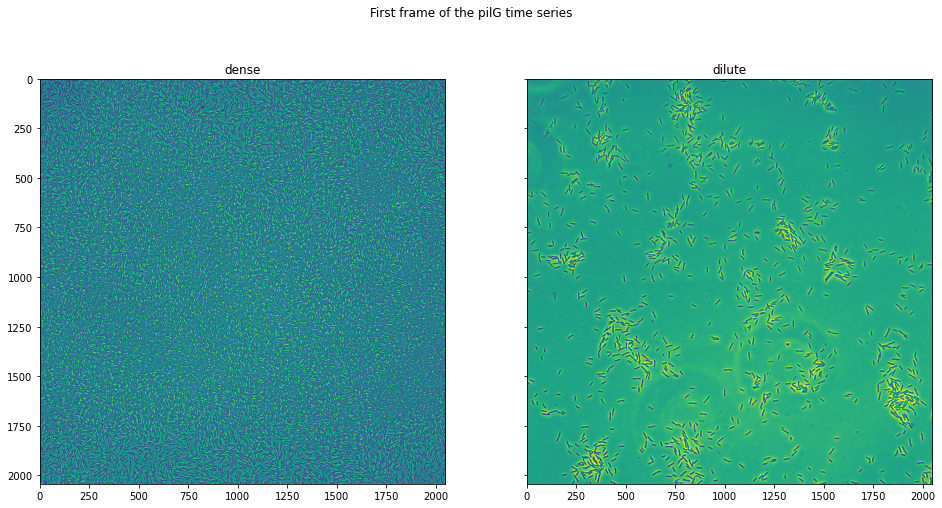

In [3]:
# read in the time series data
# read in the time series data
image_dense = ski.io.imread(os.path.join(DATA_DIR, DATA_DF['filename'][0]))
image_dilute = ski.io.imread(os.path.join(DATA_DIR, DATA_DF['filename'][1]))

# show the first frame of two time series
fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
ax[0].imshow(image_dense[0])
ax[1].imshow(image_dilute[0])
ax[0].set_title('dense')
ax[1].set_title('dilute')
# set the title of the figure
fig.suptitle('First frame of the pilG time series')
plt.show()

In order to facilitate segmentation testing and give a better visualization of the segmentation results, we crop the images to a smaller size `crop_width x crop_height` from the center of the original image.

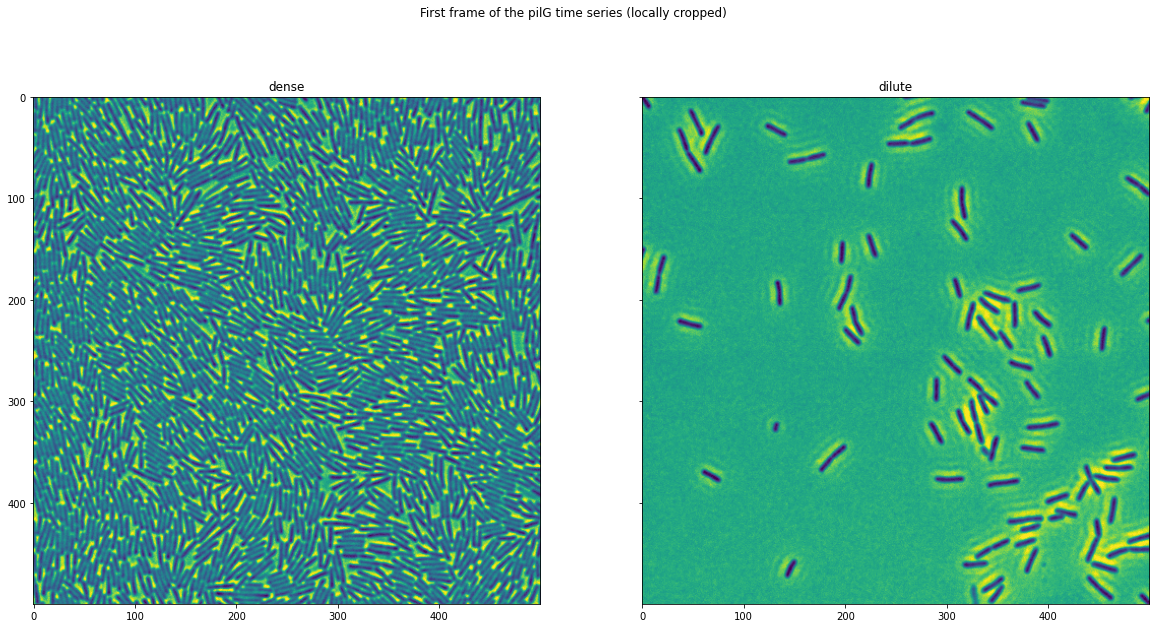

In [4]:
# crop the images
image_dense = crop_image(image_dense)
image_dilute = crop_image(image_dilute)

# show the first frame of two time series
fig, ax = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax[0].imshow(image_dense[0])
ax[1].imshow(image_dilute[0])
ax[0].set_title('dense')
ax[1].set_title('dilute')
# set the title of the figure
fig.suptitle('First frame of the pilG time series (locally cropped)')
plt.show()

## Preliminary exploration of segmentation methods

### Convensional image processing methods

#### Intensity thresholding

We start with conventional image processing methods. Given the fact that the cells have clear intensity contrast, we first attempt to use **intensity thresholding** to segment the cells.

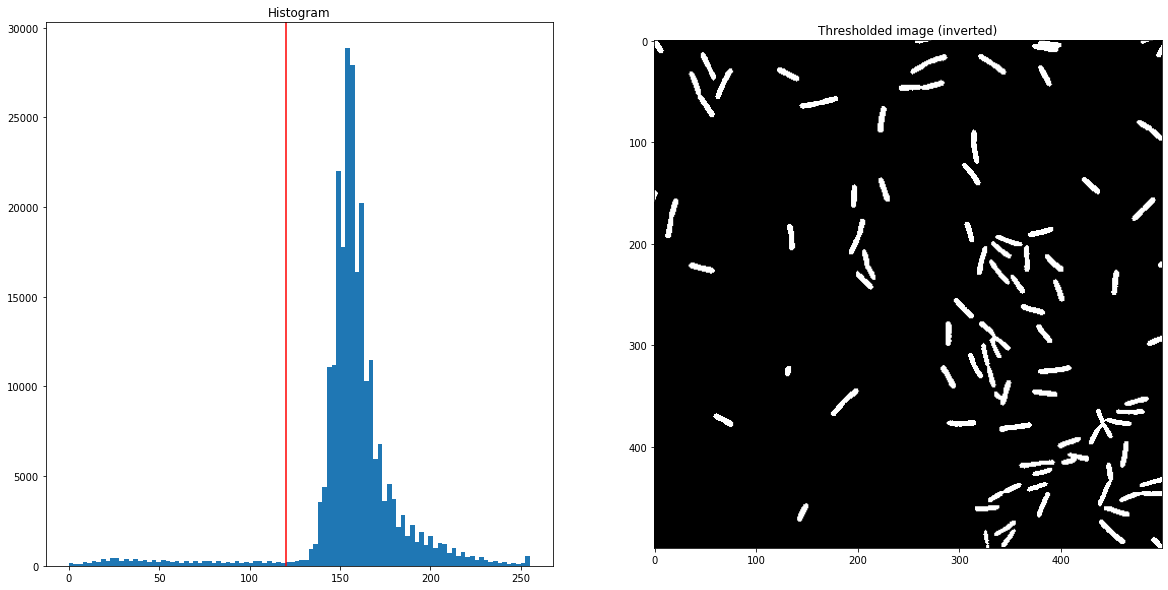

In [5]:
# try intensity thresholding on the first frame of dilute
# intensity threshold
threshold = 120

# show histogram of the first frame
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].hist(image_dilute[0].flatten(), bins=100)
# plot a vertical line at the threshold
ax[0].axvline(threshold, color='r')
ax[0].set_title('Histogram')

# threshold the first frame
image_dilute_thres = image_dilute[0] < threshold
ax[1].imshow(image_dilute_thres, cmap='gray')
ax[1].set_title('Thresholded image (inverted)')
plt.show()


The segmentation looks quite good for the dilute frame. There are some unseparated masks in the image. To distinguish the masks without significantly reducing its area, we apply grayscale watershed to the image.

c:\Users\asus\anaconda3\envs\MechanoBioIm\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


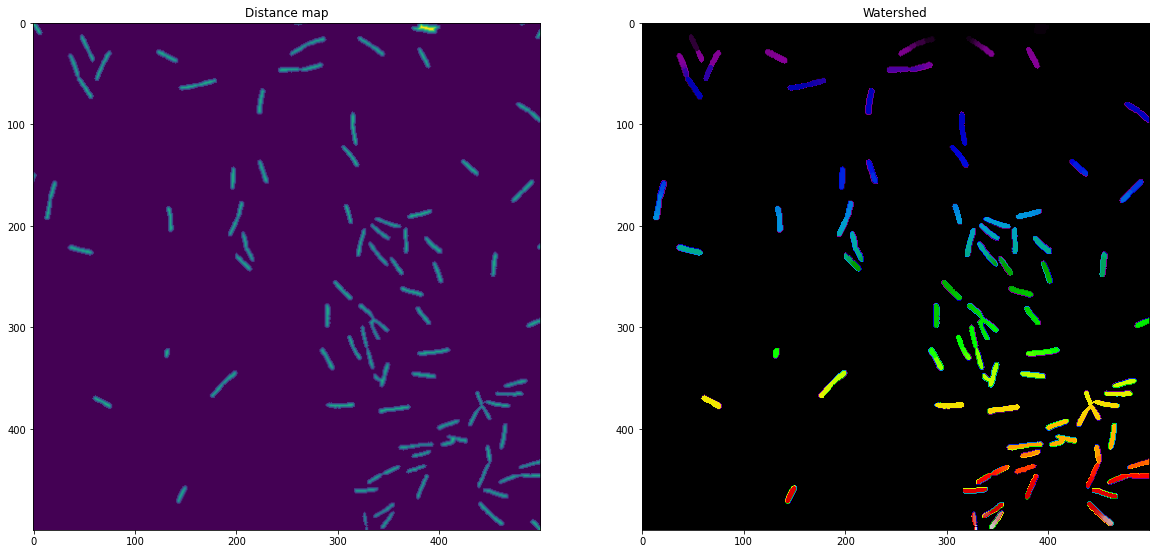

Number of cells: 338


In [6]:
# grayscale watershed with skimage
image_dilute_water = image_dilute_thres.copy()
distance = scipy.ndimage.distance_transform_edt(image_dilute_water)
# feature size of the local maxima
feature_size = 17
coords = ski.feature.peak_local_max(distance, footprint=np.ones((feature_size, feature_size)), labels=image_dilute_water)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = scipy.ndimage.label(mask)
labels = ski.morphology.watershed(-distance, markers, mask=image_dilute_water)

# show only the distance map
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(distance)
ax[0].set_title('Distance map')
ax[1].imshow(labels, cmap='nipy_spectral')
ax[1].set_title('Watershed')
plt.show()

# print the number of cells
print('Number of cells: {}'.format(np.max(labels)))

From the labelled image and estimated number of cells in the field of view, we can see that discrete objects are mistakenly separated into multiple parts (different colors presenting in the same rod-like area). This can blame to the fact that the seedings of the watershed algorithm rely on the local maxima of the image. In this scenario, the local maxima computation is parameter-dependent and sensitive to the size variation of the cells (i.e., the `feature_size` parameter). We find the same problem in the dense frame as well (not shown here). Therefore, intensity thresholding + watershed might not be a good segmentation method for this dataset.

#### Blob detection

Another conventional image processing method that came to our mind is blob detection based on **Difference of Gaussian (DoG) filtering**. DoG can be used for detecting blob-like features by the subtraction of two Gaussian-blurred images with preset `sigma` parameter matching the size of the target. We thought the rod-like cells are somewhat blob-like, so we gave it a try.

c:\Users\asus\anaconda3\envs\MechanoBioIm\lib\site-packages\skimage\feature\blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
c:\Users\asus\anaconda3\envs\MechanoBioIm\lib\site-packages\skimage\feature\blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
c:\Users\asus\anaconda3\envs\MechanoBioIm\lib\site-packages\skimage\feature\blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
c:\Users\asus\anaconda3\envs\MechanoBioIm\lib\site-packages\skimage\feature\blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
c:\Users\asus\anaconda3\envs\MechanoBioIm\lib\site-packages\skimage\feature\blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


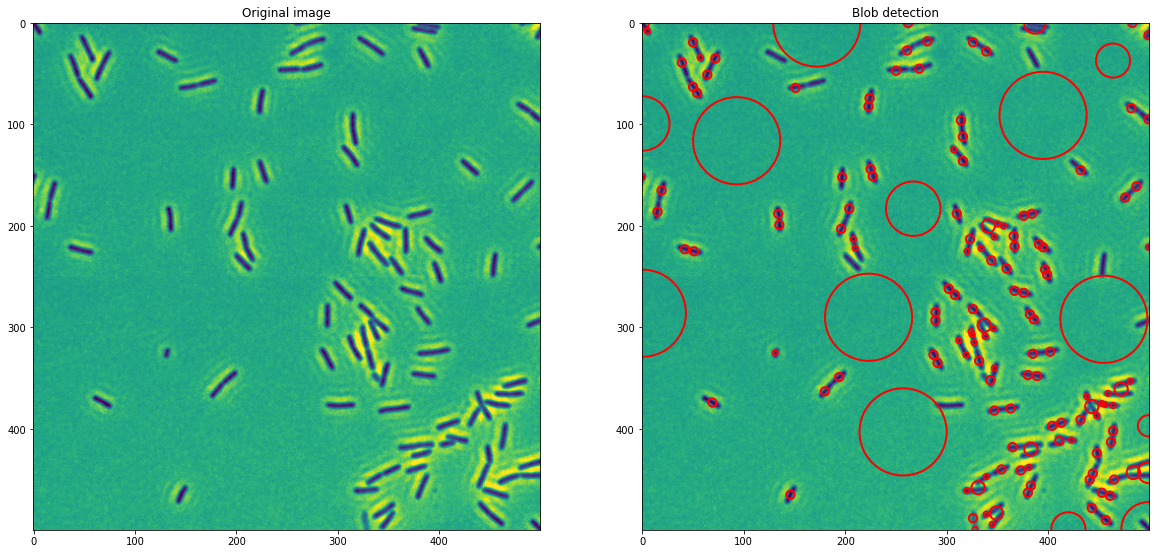

Number of cells: 151


In [7]:
# apply skimage blob detection on the inverted image
image_blob = ski.feature.blob_dog(255-image_dilute[0], min_sigma=1, max_sigma=50, threshold=.1)
# show the blobs
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(image_dilute[0])
ax[0].set_title('Original image')
ax[1].imshow(image_dilute[0])
# plot the blobs
for blob in image_blob:
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax[1].add_patch(c)
ax[1].set_title('Blob detection')
plt.show()

# print the number of cells
print('Number of cells: {}'.format(len(image_blob)))

The detection method gives a bad result with too many false positives and hard-to-intepret blobs. We think this is because the rod-like cells are not blob-like enough to be detected by DoG. Therefore, we will not use this method for further analysis.

### Deep learning based methods

From the above pilot check, we realize that because of the unique morphological feature and close proximity of the cells, the conventional image processing methods might not be able to give a good segmentation result. Therefore, we turn to deep learning based methods. Here we found [**MiSiC**](https://elifesciences.org/articles/65151), a general U-Net based model for 2D single bacterial cell segmentation.

![MiSiC_explain](./MiSiC_explain.png)

**Source**: Panigrahi, S., Murat, D., Le Gall, A., Martineau, E., Goldlust, K., Fiche, J. B., ... & Mignot, T. (2021). Misic, a general deep learning-based method for the high-throughput cell segmentation of complex bacterial communities. Elife, 10, e65151.

As shown in the figure, MiSiC represents the input image (either phase contrast, brightfield or fluorescence) as 2D shape index (SI) map. Shape index is a local geometric feature derived from the Hessian matrix of the image. The dome shape of the poles of the bacteria could be nicely captured by such feature encoding method. The SI map is then fed into a U-Net based model for segmentation.

The U-Net architecture allow the model to learn local features from the SI map while preserving the global context. The model was trained on E.coli, M.xanthus, and synthetic rod-like shape images.

The only meta-parameter of the model is the scale factor `scale` which is the conversion factor to convert the input objects into comparable size as the training data. In the training data, the bacteria have a width of 10 pixels. Therefore, the input object after scaling should also have a similar size. 

By ImageJ manual measurement, we found that the rod-like cells in our dataset have a width around 4-5 pixels. Therefore, we set the `scale` to be 2 in the following analysis. 

Last but not least, synthetic noise can be added to reduce false positives after scaling. We set the `noise` parameter to be 0.13.

Refer to [MiSiC demo code](https://github.com/pswapnesh/misic/tree/v2), we test the MiSiC model on the first frames of the dense and dilute time stacks.


In [8]:
# apply misic on only one frame
def misic_one_frame(frame, scale, light_background):
    mseg = MiSiC()
    # rescale image
    image_misic = rescale(frame, scale, preserve_range=True)
    # add local noise
    image_misic = add_noise(image_misic, 0.13, invert=light_background)
    # run misic segmentation
    yp = mseg.segment(image_misic, invert=light_background)[:,:,0]
    yp_watershed = postprocessing(yp if light_background else -image_misic, yp)
    
    return image_misic, yp, yp_watershed

In [9]:
image_misic_dilute = image_dilute[0]
image_misic_dense = image_dense[0]

# run misic on the first frame of the dilute time series
# misic parameters
# width of the training data objects
standard_width = 10
# width of the input data objects
mean_width = 5
# background intensity level
light_background = True
# scaling factor
scale = standard_width/mean_width

image_misic_dilute, yp_dilute, yp_dilute_watershed = misic_one_frame(image_misic_dilute, scale, light_background)
image_misic_dense, yp_dense, yp_dense_watershed = misic_one_frame(image_misic_dense, scale, light_background)

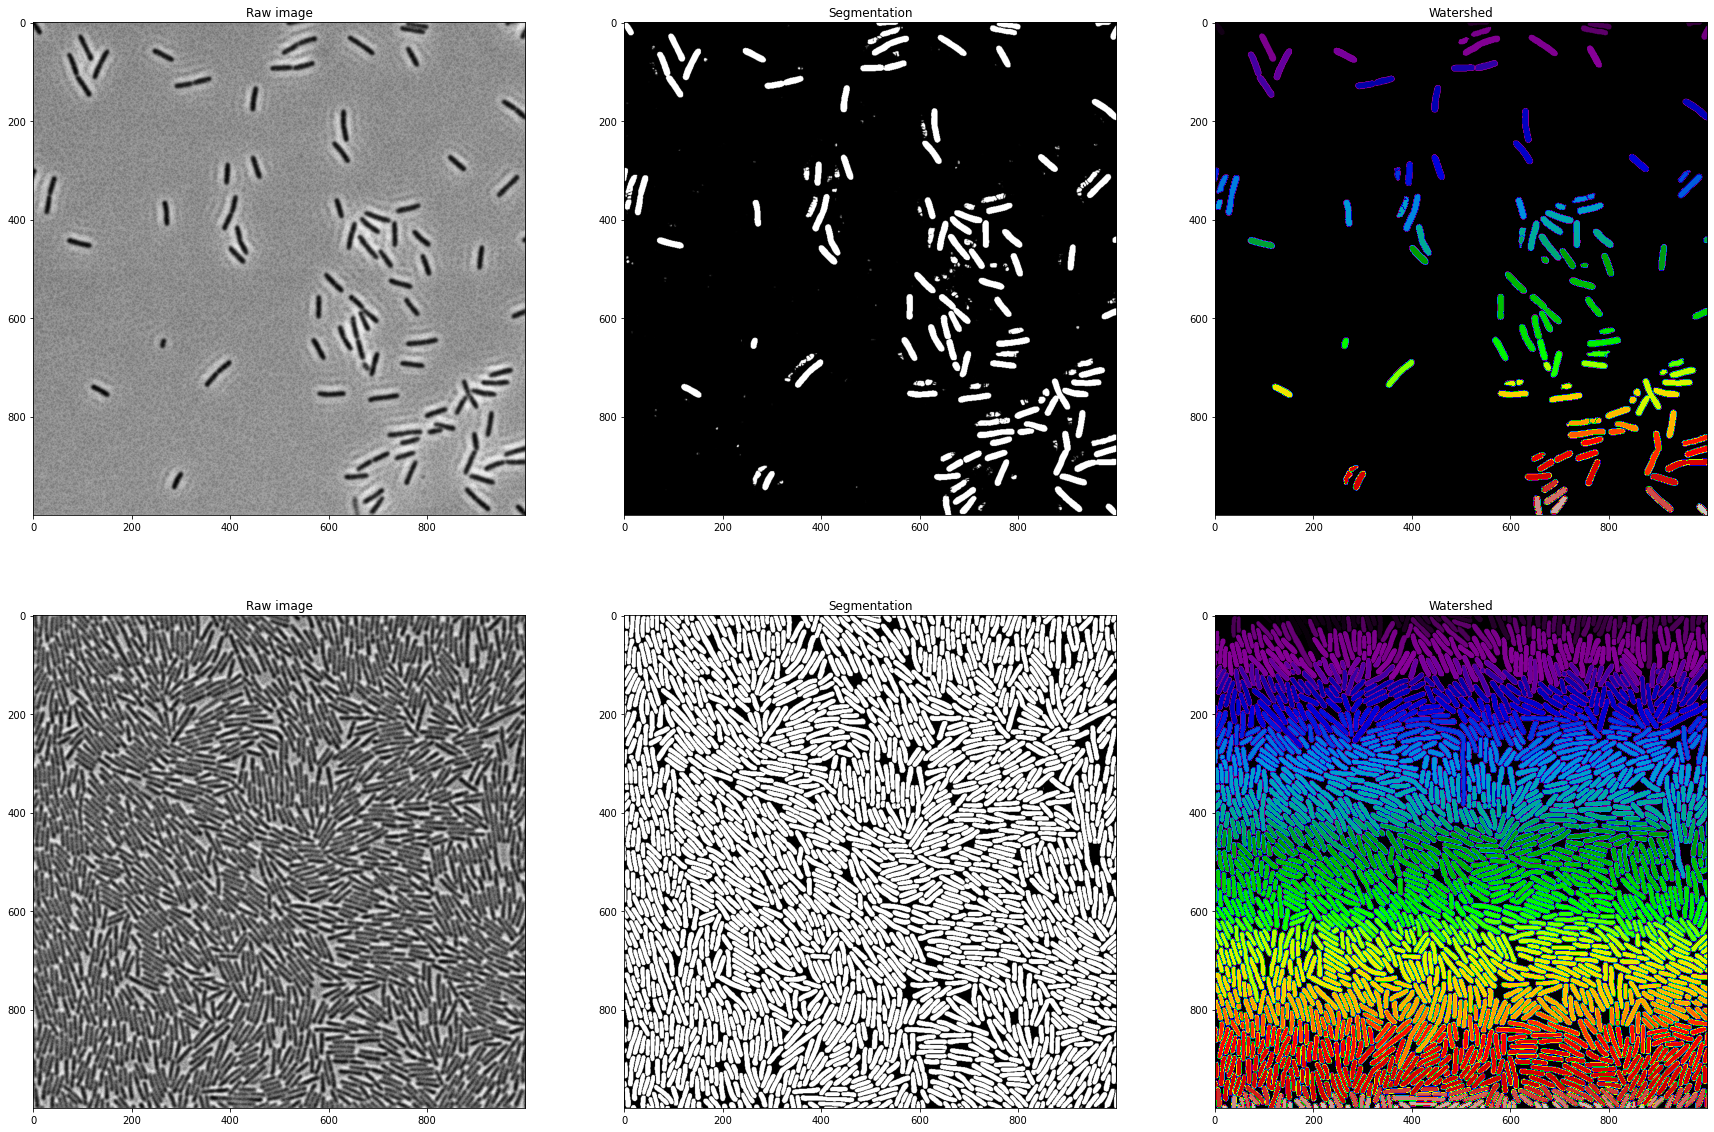

Number of cells in the pilG dilute frame: 120
Number of cells in the pilG dense frame: 1810


In [10]:
# plot the raw image, the segmentation, and the watershed
fig, ax = plt.subplots(2, 3, figsize=(30, 20))
ax[0, 0].imshow(image_misic_dilute, cmap='gray')
ax[0, 0].set_title('Raw image')
ax[0, 1].imshow(yp_dilute, cmap='gray')
ax[0, 1].set_title('Segmentation')
ax[0, 2].imshow(yp_dilute_watershed, cmap='nipy_spectral')
ax[0, 2].set_title('Watershed')
ax[1, 0].imshow(image_misic_dense, cmap='gray')
ax[1, 0].set_title('Raw image')
ax[1, 1].imshow(yp_dense, cmap='gray')
ax[1, 1].set_title('Segmentation')
ax[1, 2].imshow(yp_dense_watershed, cmap='nipy_spectral')
ax[1, 2].set_title('Watershed')
plt.show()

# print the number of cells
print('Number of cells in the pilG dilute frame: {}'.format(np.max(yp_dilute_watershed)))
print('Number of cells in the pilG dense frame: {}'.format(np.max(yp_dense_watershed)))


The performance is fantastic! Especially in the dense frame, the model can nicely separate the closely-attached cells and assign each cell a unique label. The output mask has a size of `(scale x crop_width) x (scale x crop_height)` which is the same as the scaled input image. We just need to rescale the mask back to the original size to get the segmentation result with known physical size.

Before we move on to the next step, we would like to do a simple benchmarking of the MiSiC model. We will use the dilute frame as an example. To balance between workload and quantitative evaluation, we selected 3 frames from a random fov of size 100x100px in `pilG_dilute_PC.tif` to do manual annotation and compare with the MiSiC segmentation result.

Annotation was done using [labelme](https://github.com/wkentaro/labelme) polygonal tool.

Dice score was used to evaluate the segmentation performance. The dice score is defined as:

$$DICE = \frac{2|A \cap B|}{|A| + |B|}$$

where $A$ is the ground truth annotation and $B$ is the segmentation result. The dice score ranges from 0 to 1, with 1 being the best.

In [11]:
def getdice(maskA, maskB):
    """
    Calculate the dice coefficient between two masks
    """
    # flatten the masks
    maskA = maskA.flatten()
    maskB = maskB.flatten()
    # push the masks to the same scale, 1
    maskA[maskA > 0] = 1
    maskB[maskB > 0] = 1
    # calculate the dice coefficient
    dice = 2 * np.sum(maskA * maskB) / (np.sum(maskA) + np.sum(maskB))
    return dice

In [12]:
BENCH_DIR = os.path.join(WORK_DIR, 'data', 'benchmarking')

bench_list = [os.path.basename(x) for x in glob.glob(os.path.join(BENCH_DIR, '*frame*.tif'))]
bench_image_list = [x for x in bench_list if 'mask' not in x]

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


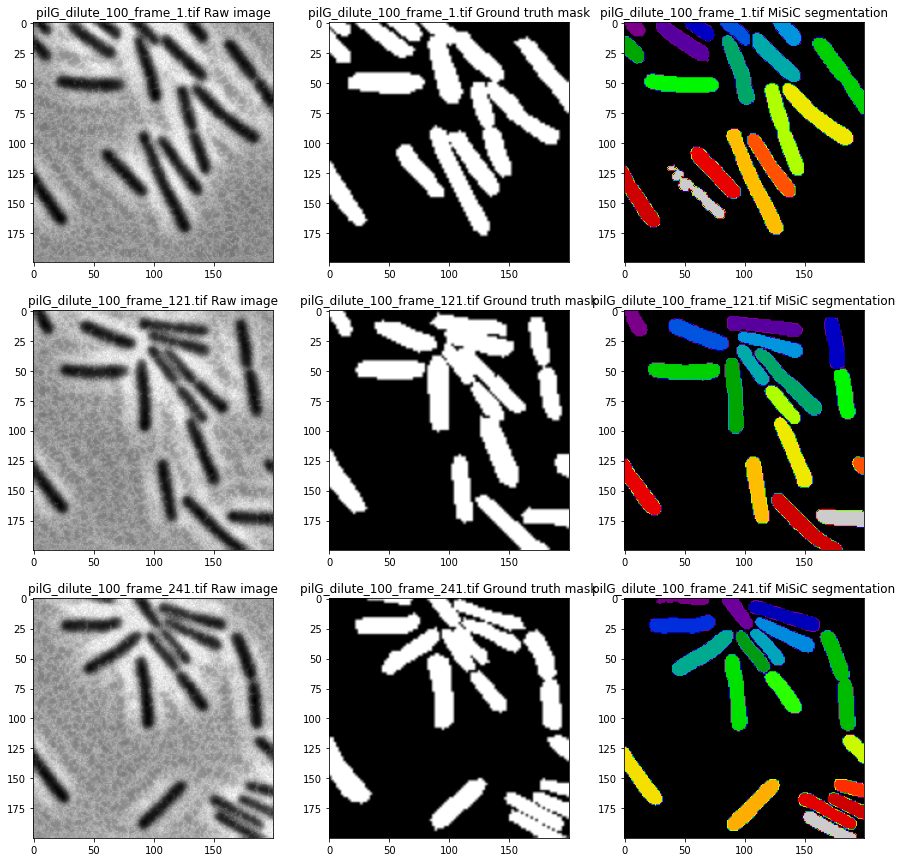

In [13]:
# initialize a sub
fig, ax = plt.subplots(3, 3, figsize=(15, 15))

dice_list = []
ind = 0
for image in bench_image_list:
    # open the image
    image_frame = ski.io.imread(os.path.join(BENCH_DIR, image))
    # open the corresponding mask
    image_mask = ski.io.imread(os.path.join(BENCH_DIR, image.replace('.tif', '_mask.tif')))
    image_mask_resized = rescale(image_mask, scale, preserve_range=True)
    # compute the segmentation
    image_misic, yp, yp_watershed = misic_one_frame(image_frame, scale, light_background)
    # compute the DICE score
    dice_list.append(getdice(image_mask_resized, yp_watershed))
    
    # plot the raw image, the mask, and the watershed
    ax[ind, 0].imshow(image_misic, cmap='gray')
    ax[ind, 0].set_title(image + ' Raw image')
    ax[ind, 1].imshow(image_mask_resized, cmap='gray')
    ax[ind, 1].set_title(image + ' Ground truth mask')
    ax[ind, 2].imshow(yp_watershed, cmap='nipy_spectral')
    ax[ind, 2].set_title(image + ' MiSiC segmentation')
    ind += 1

In [16]:
# print out the DICE score
print('DICE score: %.2f' % np.mean(dice_list))

DICE score: 0.83


As shown, the average DICE score is 0.83. It quantitatively shows that the MiSiC model can give a good segmentation result for the our dataset. In terms of segmentation quality, the continuity and completeness of the segmented cells are even better than the manual annotation. 

Given these results, we choose the MiSiC model to proceed the analysis. The only concern is the computational cost. The model doesn't support GPU acceleration and the inferfence time for a 2000px * 2000px frame is around 3-5 minutes (dependent on the CPU speed). To not lose too much time on segmentation, we decide to crop the image from the center to a reasonable size (i.e., 800px * 800px) for segmentation. We assume that the cropped area is big enough the represent the whole image.

The next step is to scale up the analysis to the corresponding spatial scale and the full time length of the time stacks.

## MiSiC segmentation scale up

To scale up and get prepared for the tracking analysis, we define class `BacTrack` to perform the following tasks:

- Time stack image segmentation using the MiSiC model
- Time stack spot detection and metadata extraction

and the method `workflow` to perform the above tasks in a sequential manner.

As shown in the subsequent `tracking.ipynb` notebook, we will apply the [`trackpy`](http://soft-matter.github.io/trackpy/v0.6.1/) package to track the segmented cells. The main goal of performing the following steps is to prepare the dataframe tailored for the tracking package input format. 

In [4]:
# define a class for performing MiSiC segmentation

class BacTrack:
    def __init__(self, image, frame_list, standard_width, mean_width, light_background):
        """
        Args:
            image (3D numpy array of shape (time, y, x)): the image to be segmented
            frame_list (1D numpy array): the frame number to be segmented
            standard_width (float): the standard width of the object
            mean_width (float): the mean width of the object
            light_background (bool): whether the background is light or dark
        """
        self.image = image
        self.frame_list = frame_list
        self.scale = int(standard_width / mean_width)
        self.light_background = light_background
        self.mseg = MiSiC()
        
        # initialize the output
        # the mask stack
        self.yp_stack = np.zeros((len(frame_list), self.scale * self.image.shape[1], self.scale * self.image.shape[2]))
        # the metadata (pd.DataFrame)
        self.spot_metadata = pd.DataFrame(columns=['frame', 'centroid-0', 'centroid-1', 'area', 'orientation', 'major_axis_length', 'minor_axis_length'])
        
    def segment(self):
        """
        Perform segmentation on each frame in the frame list.
        The result is stored in self.yp_stack
        """
        for tf in tqdm.tqdm(self.frame_list):
            frame = self.image[tf,:,:]
            # rescale the image
            frame_resc = rescale(frame, self.scale, preserve_range=True)
            # add noise
            frame_resc = add_noise(frame_resc, sensitivity=0.13, invert = self.light_background)
            # segment the image
            yp = self.mseg.segment(frame_resc, invert = self.light_background)[:,:,0]
            # resize the image
            #yp = resize(yp, (crop_height, crop_width))
            # watershed the image
            yp_watershed = postprocessing(frame_resc if self.light_background else -frame_resc, yp)
            # store the image
            self.yp_stack[tf,:,:] = yp_watershed
            
    def detection(self):
        """
        Perform detection on each frame in the frame list.
        Store metadata in self.spot_metadata
        """
        for i in tqdm.tqdm(range(len(self.frame_list))):
            tf = self.frame_list[i]
            yp = self.yp_stack[i,:,:]
            # detect the spots
            # generate metadata: centroid, area, orientation, major_axis_length, minor_axis_length
            metadata = ski.measure.regionprops_table(yp.astype(int), properties=['centroid', 'area', 'orientation', 'major_axis_length', 'minor_axis_length'])
            metadata = pd.DataFrame(metadata)
            # rescale the centroid and area back to the original scale
            metadata['centroid-0'] = metadata['centroid-0'] / self.scale
            metadata['centroid-1'] = metadata['centroid-1'] / self.scale
            metadata['area'] = metadata['area'] / (self.scale ** 2)
            metadata['major_axis_length'] = metadata['major_axis_length'] / self.scale
            metadata['minor_axis_length'] = metadata['minor_axis_length'] / self.scale
            # store the metadata with frame number
            metadata['frame'] = tf
            self.spot_metadata = self.spot_metadata.append(pd.DataFrame(metadata), sort = False)
        
        # rename the columns
        # change centroid-0 to x, and centroid-1 to y
        self.spot_metadata = self.spot_metadata.rename(columns={'centroid-0': 'x', 'centroid-1': 'y', 'area': 'size'})

In [5]:
# define a full workflow for performing segmentation and detection for all files in the data directory
def workflow(folder, file_list, crop_width, crop_height, standard_width, mean_width, light_background):
    """
    Args:
        folder (str): the folder containing the files to be segmented
        file_list (list): a list of file names to be segmented
        crop_width (int): the width of the cropped image
        crop_height (int): the height of the cropped image
        standard_width (float): the standard width of the object
        mean_width (float): the mean width of the object
        light_background (bool): whether the background is light or dark
    """
    # create the output folder
    if not os.path.exists(os.path.join(folder, 'output')):
        os.makedirs(os.path.join(folder, 'output'))
    # create the metadata folder
    if not os.path.exists(os.path.join(folder, 'metadata')):
        os.makedirs(os.path.join(folder, 'metadata'))
    
    # loop through all files
    for file in file_list:
        print('Processing file: {}'.format(file))
        # read in the time series data
        image = ski.io.imread(os.path.join(folder, file))
        # set max_frame to the length of the time series if not specified
        print(image.shape[0])
        max_frame = image.shape[0]
        # crop the image by time and by space
        image = image[:max_frame,:,:]
        image = crop_image(image, crop_width, crop_height)
        # get the frame number (by default full length)
        n_frame = np.arange(0, max_frame)
        # initialize a BacTrack object
        bactrack = BacTrack(image, n_frame, standard_width, mean_width, light_background)
        # segment the image
        bactrack.segment()
        # detect the spots
        bactrack.detection()
        # save the output
        yp_stack_single_gray = np.zeros_like(bactrack.yp_stack)
        for i in range(len(n_frame)):
            yp_stack_single_gray[i][bactrack.yp_stack[i] != 0] = 255
        # save the mask stack
        # the image and the mask are not the same size due to the scaling factor
        ski.io.imsave(os.path.join(folder, 'output', file.replace('.tif', '_raw_image_{}_{}.tif'.format(crop_width, crop_height))), image.astype(np.uint16))
        ski.io.imsave(os.path.join(folder, 'output', file.replace('.tif', '_raw_mask_{}_{}.tif'.format(crop_width, crop_height))), bactrack.yp_stack.astype(np.uint16))
        ski.io.imsave(os.path.join(folder, 'output', file.replace('.tif', '_gray_mask_{}_{}.tif'.format(crop_width, crop_height))), yp_stack_single_gray.astype(np.uint8))
        # save the metadata
        # name the file with crop size
        output_name = file.replace('.tif', '_metadata_{}_{}.csv'.format(crop_width, crop_height))
        bactrack.spot_metadata.to_csv(os.path.join(folder, 'metadata', output_name))


Start the analysis of all time stacks in the `DATA_LIST`. Each time stack takes approximatedly 2 hrs to finish. The raw images and segmentation masks (grayscale and labelled) are saved in the `./data/output` folder, and the metadata are saved in the `./data/metadata` folder.

In [43]:
# run the workflow
# misic parameters
crop_width = 800
crop_height = 800

In [ ]:
standard_width = 10
mean_width = 5
light_background = True
DATA_PLAN = DATA_LIST[4:6]
workflow(DATA_DIR, DATA_PLAN, crop_width, crop_height, standard_width, mean_width, light_background)

*(The output of the workflow is skipped intentionally)*

After the analyzing all the positions, we decide to merge all the metadata into a single dataframe for further analysis.

In [11]:
# put all metadata into one file
# get all metadata files
metadata_list = glob.glob(os.path.join(DATA_DIR, 'metadata', '*metadata*.csv'))
# read in all metadata files as dataframes, add a column for the file name

big_df = pd.DataFrame()
for metadata in metadata_list:
    # read in the metadata, add a column for the file name
    # get the file name
    filename = os.path.basename(metadata).replace('_metadata_{}_{}.csv'.format(crop_width, crop_height), '')
    # read in the metadata
    df = pd.read_csv(metadata, index_col=0)
    # add a column for the file name
    df['filename'] = filename
    # append the dataframe to the big dataframe
    big_df = big_df.append(df, sort=False)

c:\Users\ychiang\AppData\Local\anaconda3\envs\MechanoBioIm\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [12]:
big_df.head()

frame         x          y   size  orientation  major_axis_length  \
0      0  4.230303   8.472727  41.25     0.304692          10.823255   
1      0  5.352423  21.845815  56.75    -0.379875          13.491528   
2      0  7.279197  27.319343  68.50    -0.216216          17.407289   
3      0  7.518272  32.898671  75.25    -0.258081          19.283956   
4      0  2.393130  55.221374  32.75     1.033059           8.170851   

   minor_axis_length       filename  
0           4.971094  pilG_dense_PC  
1           5.450504  pilG_dense_PC  
2           5.236532  pilG_dense_PC  
3           5.270044  pilG_dense_PC  
4           5.212592  pilG_dense_PC

In [13]:
big_df.to_csv(os.path.join(DATA_DIR, 'metadata', 'big_df.csv'))

## Orientation Analysis

According to [`skimage.measure.regionprops` documentation](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops), the returned orientation is a measurement ranging from $-\pi/2$ to $\pi/2$ of the angle between the x-axis (**the horizontal axis**, due to the transpose effect derived from the bizarre image coordinate system) and the major axis of the ellipse that has the same second-moments as the region (i.e., the angle between x-axis and the major axis). It can be used to quantify the alignment of the bacteria in their population.

In Part C Question 1, we are asked to plot the evolution of nematic order parameter $S$ over time. The nematic order parameter is defined as:

$$S = \frac{1}{N} \sum_{i=1}^{N} \frac{3\cos^2\theta_i - 1}{2}$$

where $N$ is the total number of bacteria in the given field of view, and $\theta_i$ is the orientation of the $i$-th bacteria. The nematic order parameter ranges from -0.5 to 1, with 1 being the most aligned state.

The whole size of the frame is 800px * 800px = 130um * 130um. We decide to divide the frame into grids of size 80px * 80px = 13um * 13um, and compute the nematic order parameter for each grid. The grid size is chosen to be 80px to make sure that each grid has good enough amount of bacteria to represent the local alignment. The resulting map should be a 10 * 10 matrix evolving over time.

### Preprocessing

Before head into the analysis, we need to do some preprocessing to filter out diluted samples and falsely segmented bacteria. A possible way is to filter out the bacteria with area smaller than a threshold or with a nearly identical major/minor axis length. 

In [6]:
# read in big_df
big_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata', 'big_df.csv'), index_col=0)

# only keep the files of filename with *dense*
big_df = big_df[big_df['filename'].str.contains('dense')]
big_df.head()

c:\Users\ychiang\AppData\Local\anaconda3\envs\MechanoBioIm\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


frame         x          y   size  orientation  major_axis_length  \
0      0  4.230303   8.472727  41.25     0.304692          10.823255   
1      0  5.352423  21.845815  56.75    -0.379875          13.491528   
2      0  7.279197  27.319343  68.50    -0.216216          17.407289   
3      0  7.518272  32.898671  75.25    -0.258081          19.283956   
4      0  2.393130  55.221374  32.75     1.033059           8.170851   

   minor_axis_length       filename  
0           4.971094  pilG_dense_PC  
1           5.450504  pilG_dense_PC  
2           5.236532  pilG_dense_PC  
3           5.270044  pilG_dense_PC  
4           5.212592  pilG_dense_PC

First we perform size-wise filtering.

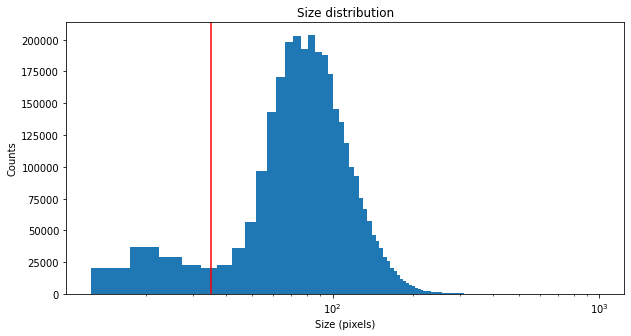

In [22]:
# plot the size distribution, set x axis to log scale
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(big_df['size'], bins=200)
ax.set_xlabel('Size (pixels)')
ax.set_ylabel('Counts')
ax.set_title('Size distribution')
ax.set_xscale('log')

# set threshold as 30, plot th vertical line
size_threshold = 35
ax.axvline(threshold, color='r')
plt.show()

It seems like there's an enriched population of small objects of size between 0 and 35 pixels. Objects of such sizes are likely to be falsely segmented bacteria. Therefore, we decide to filter out the objects with area smaller than 35 pixels.

Then we perform major/minor axis length-wise filtering. Due to the fact that P.aeruginosa is rod-like, the major/minor axis length of the bacteria should be significantly different.

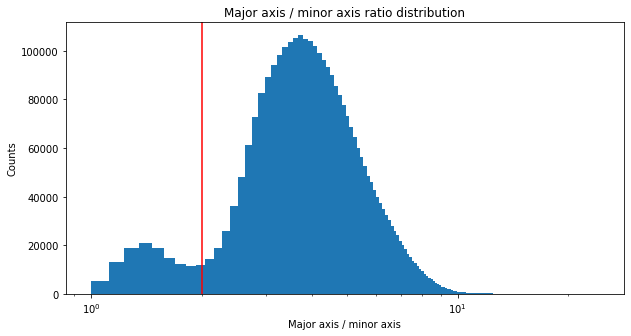

In [23]:
# plot the major axis / minor axis ratio distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(big_df['major_axis_length'] / big_df['minor_axis_length'], bins=200)
ax.set_xlabel('Major axis / minor axis')
ax.set_ylabel('Counts')
ax.set_title('Major axis / minor axis ratio distribution')
ax.set_xscale('log')

ratio_threshold = 2
ax.axvline(ratio_threshold, color='r')
plt.show()

Similarly, we find that there's an enriched population of objects with major/minor axis length ratio below 2, which doesn't make sense for rod-like bacteria. Therefore, we decide to filter out the objects with major/minor axis length ratio below 2.

In [20]:
# filter the dataframe
print("Number of data points before filtering: {}".format(len(big_df)))
big_df_filtered = big_df[(big_df['size'] > size_threshold) & (big_df['major_axis_length'] / big_df['minor_axis_length'] > ratio_threshold)]
print("Number of data points after filtering: {}".format(len(big_df_filtered)))

Number of data points before filtering: 3109905
Number of data points after filtering: 2968335


Define method for computing nematic order parameter.

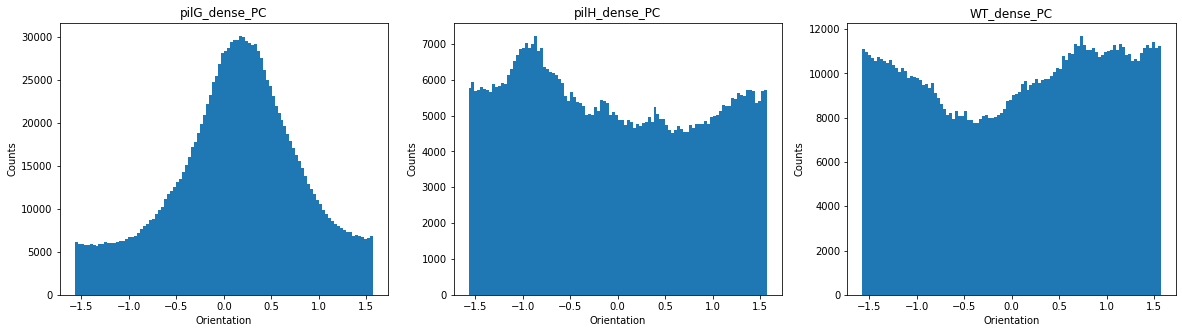

In [25]:
# plot the distribution of orientation of each file
# get the list of filenames
filename_list = big_df_filtered['filename'].unique()
# initialize a figure
fig, ax = plt.subplots(1, len(filename_list), figsize=(20, 5))
# loop through each file
for i in range(len(filename_list)):
    # get the filename
    filename = filename_list[i]
    # get the dataframe for this file
    df = big_df_filtered[big_df_filtered['filename'] == filename]
    # plot the histogram
    ax[i].hist(df['orientation'], bins=100)
    ax[i].set_title(filename)
    ax[i].set_xlabel('Orientation')
    ax[i].set_ylabel('Counts')

From the quick visualization of the orientation over files, we can already capture some interesting differences. `pilG_dense_PC` has a sharp peak in low orientation angle, indicating a highly-vertically aligned population, whereas the other two samples have a relatively uniform distribution of orientation angle, indicating a less-aligned population.

To proceed, we define method for computing nematic order parameter.

In [26]:
def get_nop(df):
    """Obtain the local nematic order parameter from the dataframe

    Args:
        df (pd.DataFrame): the dataframe containing the metadata
        
    Returns:
        nop (float): the local nematic order parameter, ranging 
    """
    num_cells = len(df)
    nop = 0
    for i in range(num_cells):
        nop += (3*np.cos(df['orientation'].iloc[i])**2 - 1) / 2
    nop = nop / num_cells
    
    return nop

In [28]:
# hyperparameters
max_dim = 800
gid_dim = 80
num_grid = int(max_dim / gid_dim)

# initialize dictionaries for storing the data
nop_dict = {}

# loop through each file
for filename in filename_list:
    print('Processing file: {}'.format(filename))
    # get the dataframe for this file
    df = big_df_filtered[big_df_filtered['filename'] == filename]
    # initialize a matrix for storing the nop
    # nframe is the maximum frame number
    nframe = df['frame'].max()+1
    nop_matrix = np.zeros((nframe, num_grid, num_grid))
    for tf in tqdm.tqdm(range(nframe)):
        # get the dataframe for this frame
        df_frame = df[df['frame'] == tf]
        for xind in range(num_grid):
            for yind in range(num_grid):
                # get the dataframe for this grid
                df_grid = df_frame[(df_frame['x'] > xind * gid_dim) & (df_frame['x'] < (xind + 1) * gid_dim) & (df_frame['y'] > yind * gid_dim) & (df_frame['y'] < (yind + 1) * gid_dim)]
                # calculate the local nematic order parameter
                nop_matrix[tf, xind, yind] = get_nop(df_grid)
    # store the nop matrix in the dictionary
    nop_dict[filename] = nop_matrix
                
                

Processing file: pilG_dense_PC


  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 301/301 [01:30<00:00,  3.34it/s]


Processing file: pilH_dense_PC


100%|██████████| 201/201 [00:49<00:00,  4.07it/s]


Processing file: WT_dense_PC


100%|██████████| 201/201 [01:00<00:00,  3.34it/s]


Let's have a glance at the nematic order parameter evolution of the first frame of `pilG_dense_PC`.

Max: 0.9501633415336543
Min: -0.29681810152503835


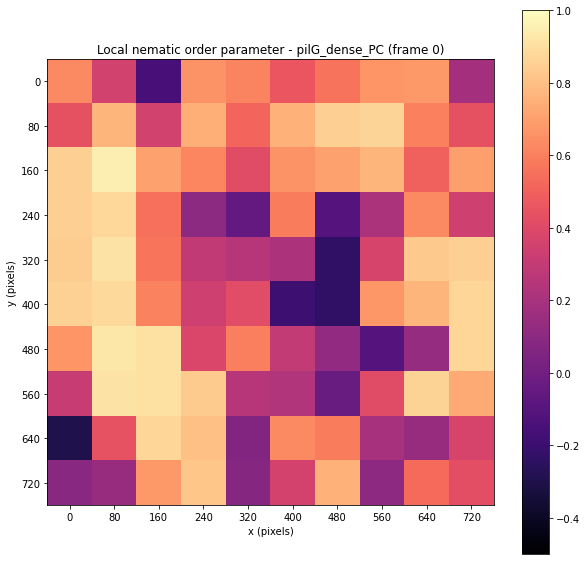

In [41]:
# plot the nop matrix
fig, ax = plt.subplots(figsize=(10, 10))
nop_plot = ax.imshow(nop_dict[filename_list[0]][0,:,:], vmin=-0.5, vmax=1, cmap='magma')
# print max and min
print('Max: {}'.format(np.max(nop_dict[filename_list[0]][0,:,:])))
print('Min: {}'.format(np.min(nop_dict[filename_list[0]][0,:,:])))
# show the colorbar
plt.colorbar(nop_plot)
# label the x and y axis as grid index * grid dimension
ax.set_xticks(np.arange(0, num_grid, 1))
ax.set_yticks(np.arange(0, num_grid, 1))
ax.set_xticklabels(np.arange(0, num_grid, 1) * gid_dim)
ax.set_yticklabels(np.arange(0, num_grid, 1) * gid_dim)
# set the x and y axis label
ax.set_xlabel('x (pixels)')
ax.set_ylabel('y (pixels)')
# set title as the filename + frame number
ax.set_title('Local nematic order parameter - ' + filename_list[0] + ' (frame 0)')
plt.show()


The brighter pixels indicate a higher nematic order parameter, aka better alignment along the vertical direction.

We save the resulting time stack as a `.tif` file also in the `./data/output` folder.

In [71]:
# save the nop time stack
# loop through each file
for filename in filename_list:
    print('Processing file: {}'.format(filename))
    # to match the image coordinate system, transpose the nop matrix
    # don't need to flip because the nop matrix is filled from top to bottom, same as the image
    nop_matrix = nop_dict[filename]
    #nop_matrix = np.transpose(nop_matrix, (0, 2, 1))
    # resize the nop matrix to the original size, 16bit integer
    nop_matrix_rsc = np.zeros((nop_matrix.shape[0], max_dim, max_dim), dtype=np.float32)
    for tf in tqdm.tqdm(range(nop_matrix.shape[0])):
        # apply the INTER_AREA interpolation method
        nop_matrix_rsc[tf,:,:] = ski.transform.resize(nop_matrix[tf,:,:], (max_dim, max_dim), order=0, preserve_range=True)
    # save the stack
    ski.io.imsave(os.path.join(DATA_DIR, 'output', filename + '_nop_{}_{}.tif'.format(crop_width, crop_height)), nop_matrix_rsc)

Processing file: pilG_dense_PC


  0%|          | 0/301 [00:00<?, ?it/s]

100%|██████████| 301/301 [00:03<00:00, 85.90it/s]


Processing file: pilH_dense_PC


100%|██████████| 201/201 [00:02<00:00, 87.18it/s]


Processing file: WT_dense_PC


100%|██████████| 201/201 [00:02<00:00, 82.59it/s]


We will create the overlay of the nematic order parameter map on the original image for better visualization using ImageJ/Fiji.

Last but not least, we plot the average and standard deviation of the nematic order parameter over time.

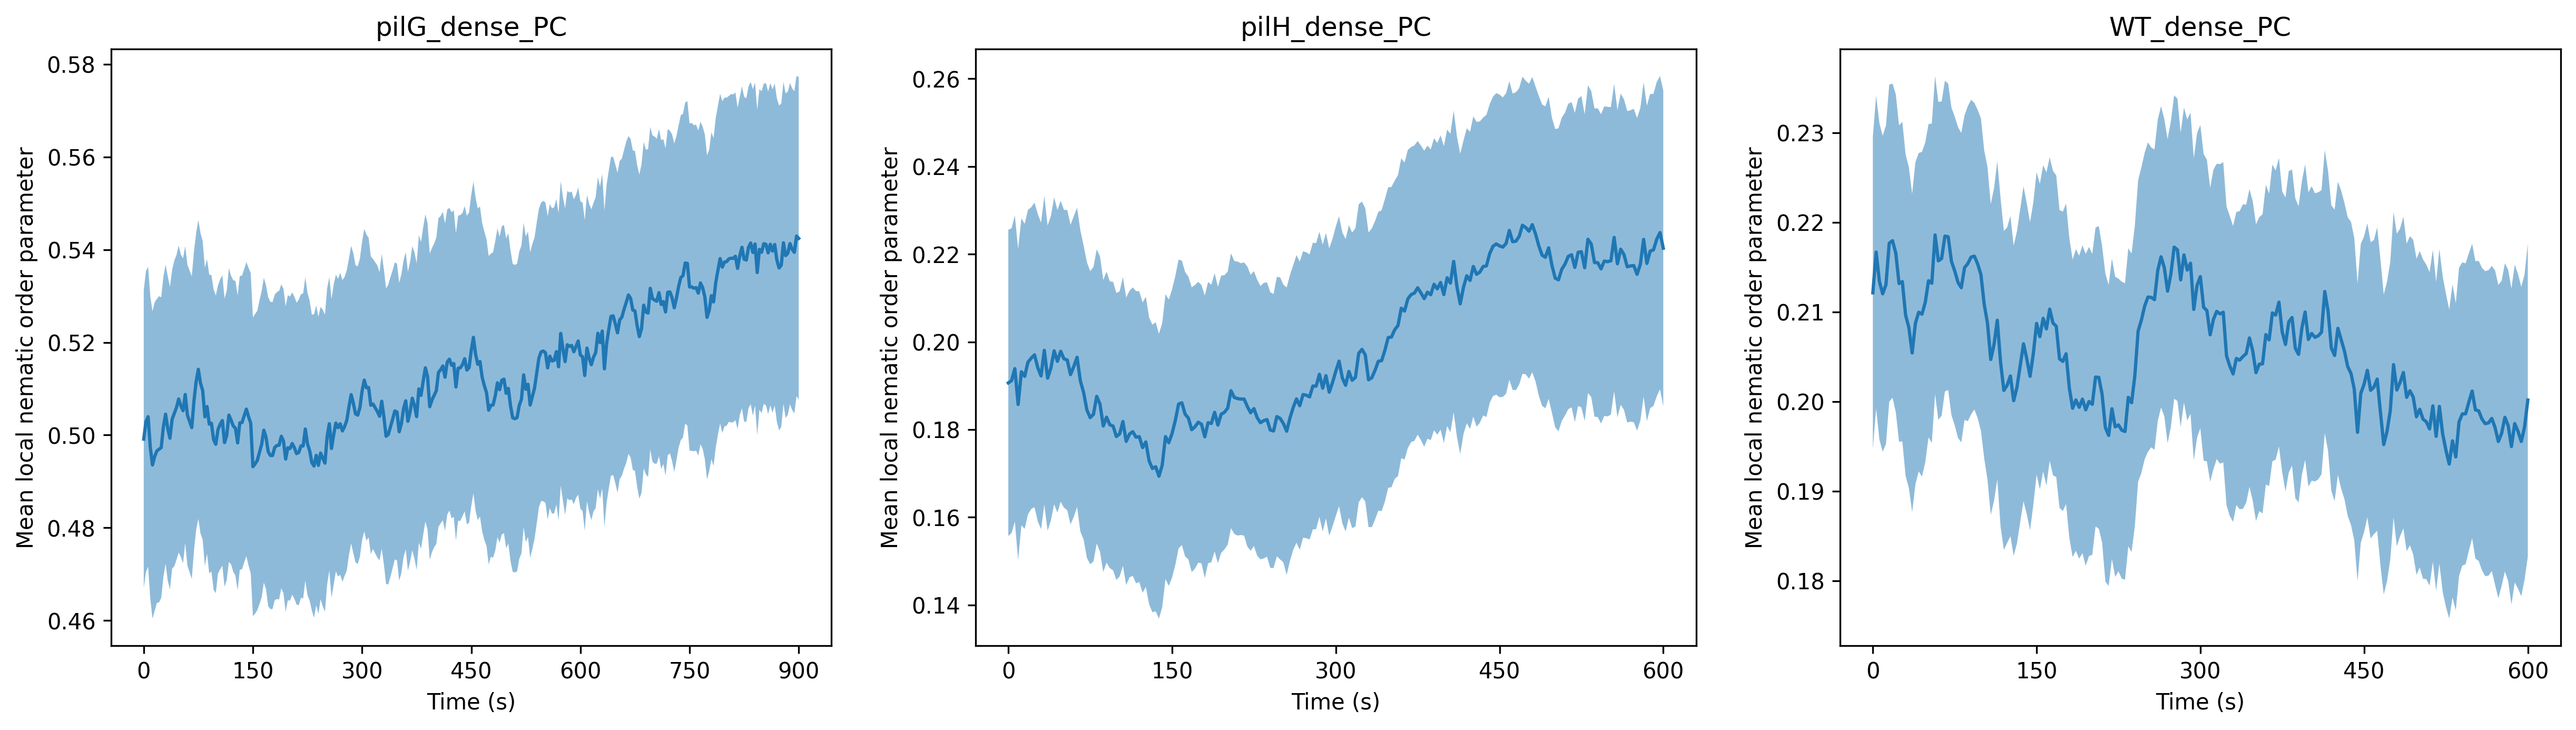

In [84]:
# plot the nop time stack mean and std for each file over time
fig, ax = plt.subplots(1, len(filename_list), figsize=(20, 5))
# set dpi to 300 for publication
fig.dpi = 300
for i in range(len(filename_list)):
    filename = filename_list[i]
    nop_matrix = nop_dict[filename]
    nop_mean = np.mean(nop_matrix, axis=(1, 2))
    nop_std = np.std(nop_matrix, axis=(1, 2))
    ax[i].plot(nop_mean)
    ax[i].fill_between(np.arange(len(nop_mean)), nop_mean - nop_std/num_grid, nop_mean + nop_std/num_grid, alpha=0.5)
    ax[i].set_title(filename)
    # set x ticks into seconds, frame interval is 3s
    ax[i].set_xticks(np.arange(0, len(nop_mean), 50))
    ax[i].set_xticklabels(np.arange(0, len(nop_mean), 50) * 3)
    ax[i].set_xlabel('Time (s)')
    ax[i].set_ylabel('Mean local nematic order parameter')
plt.show()

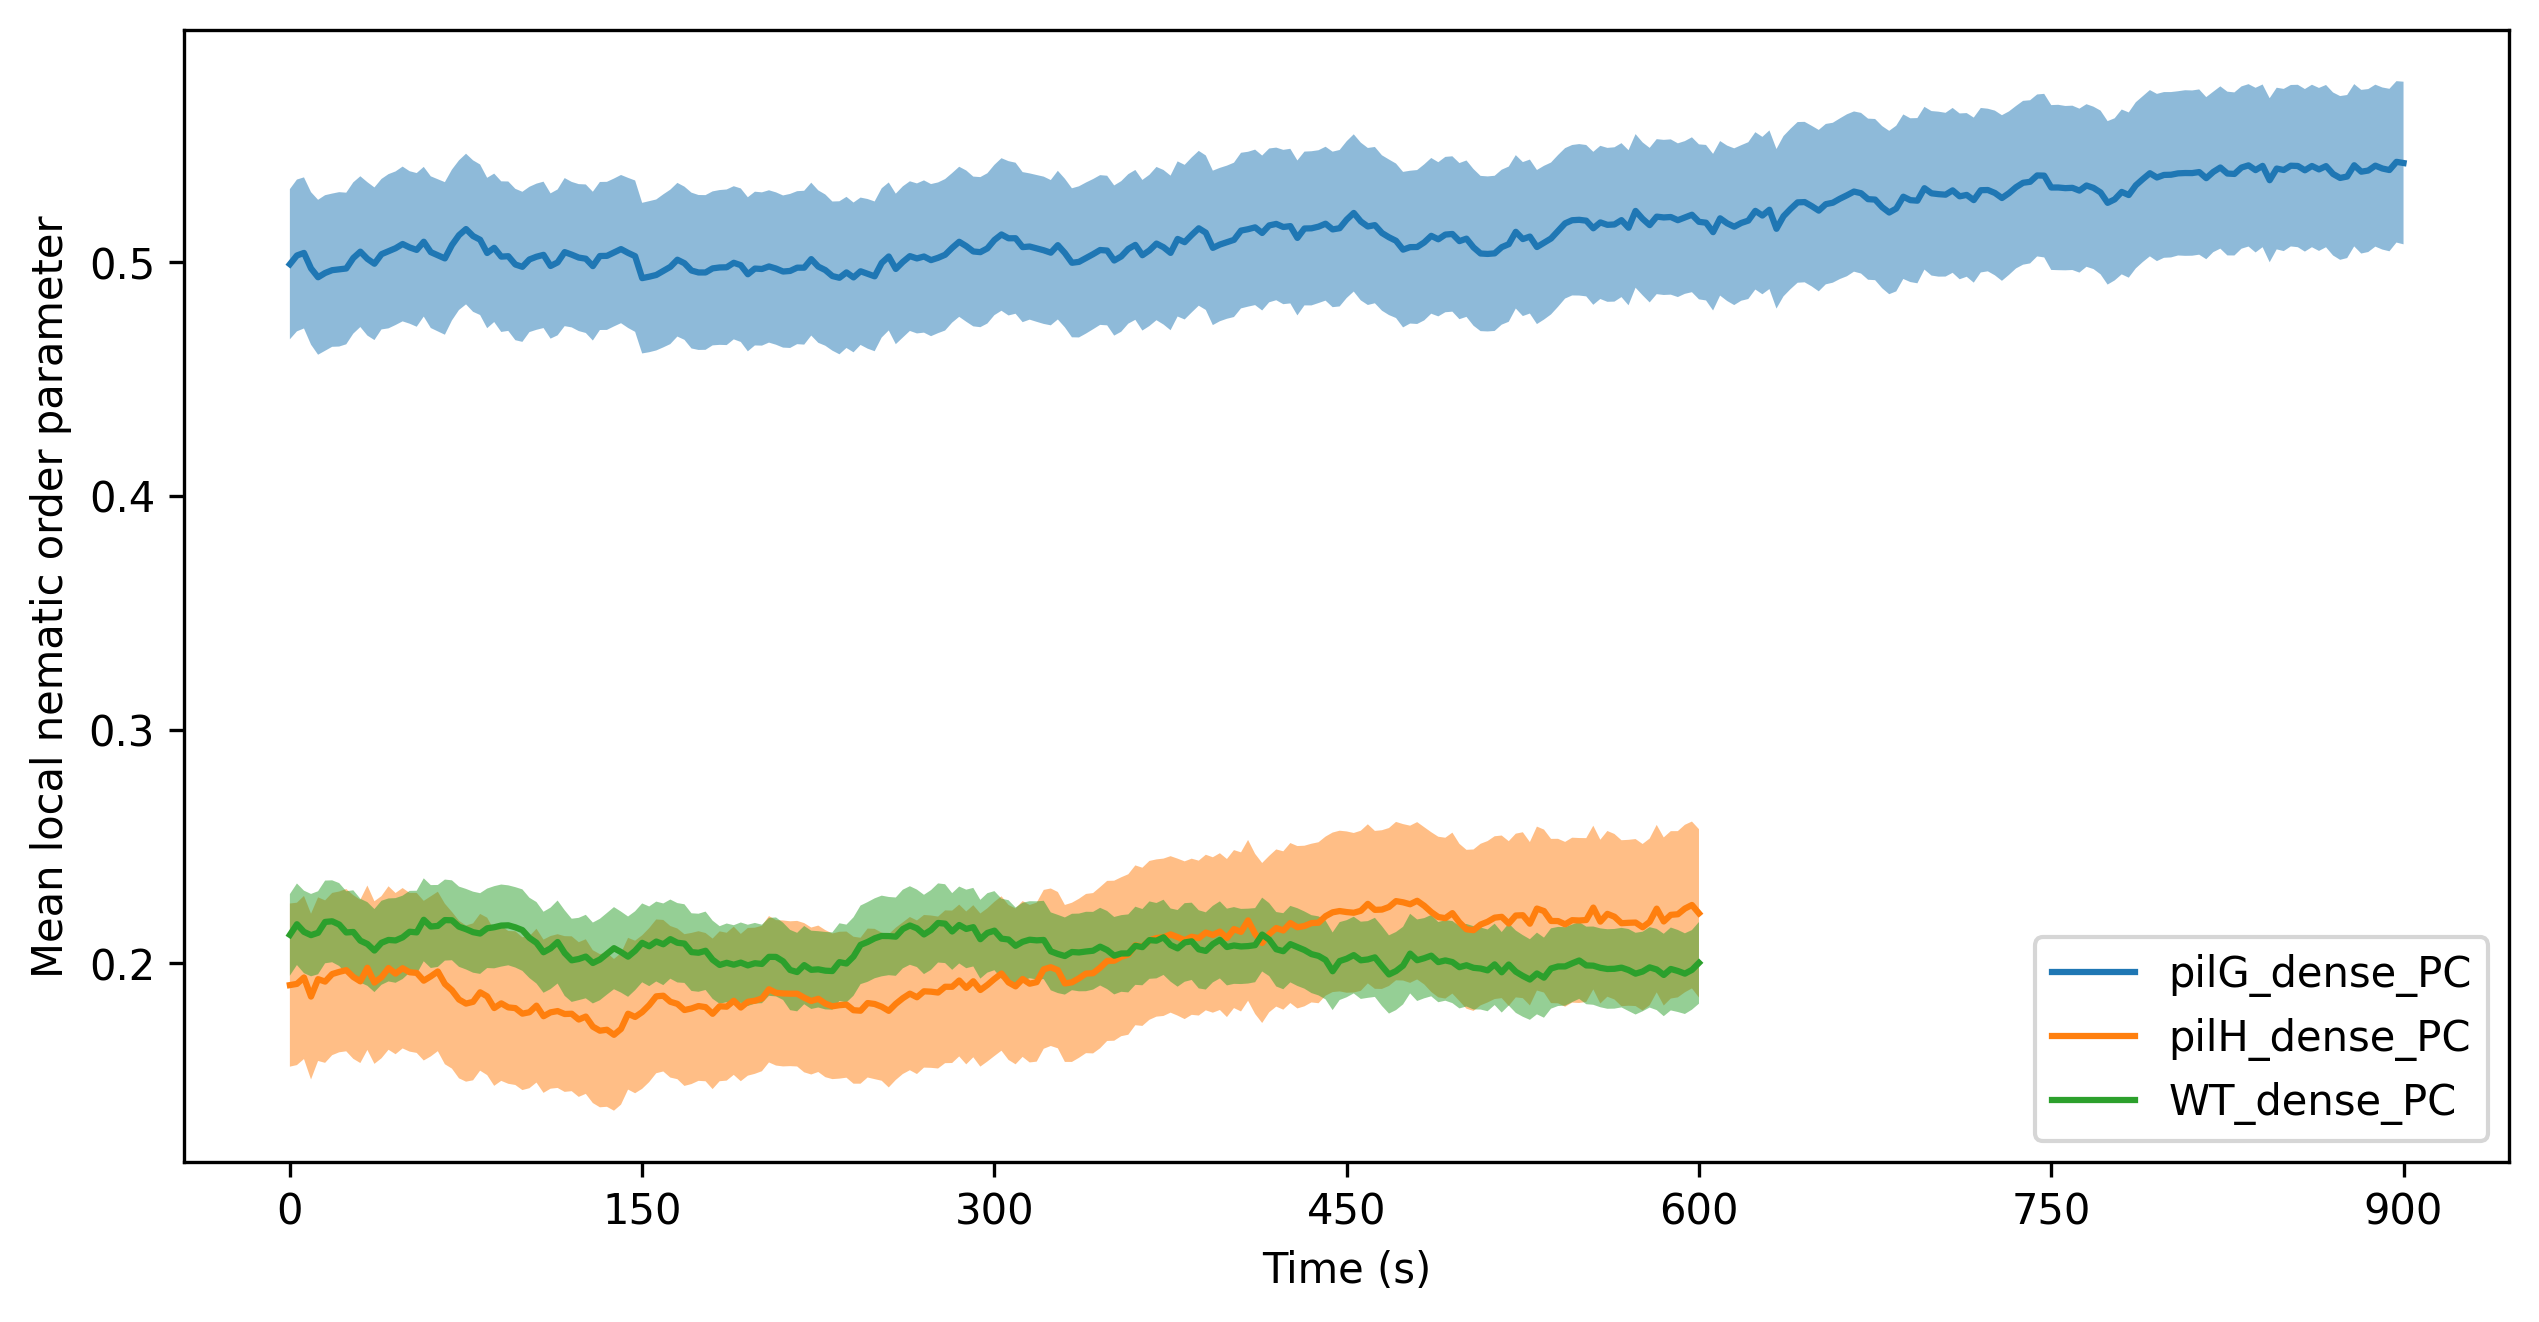

In [88]:
# plot the same thing, but on the same plot
fig, ax = plt.subplots(figsize=(10, 5))
# set dpi to 300 for publication
fig.dpi = 300
for i in range(len(filename_list)):
    filename = filename_list[i]
    nop_matrix = nop_dict[filename]
    nop_mean = np.mean(nop_matrix, axis=(1, 2))
    nop_std = np.std(nop_matrix, axis=(1, 2))
    ax.plot(nop_mean, label=filename)
    ax.fill_between(np.arange(len(nop_mean)), nop_mean - nop_std/num_grid, nop_mean + nop_std/num_grid, alpha=0.5)
    # set x ticks into seconds, frame interval is 3s
    if i == 0:
        ax.set_xticks(np.arange(0, len(nop_mean), 50))
        ax.set_xticklabels(np.arange(0, len(nop_mean), 50) * 3)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mean local nematic order parameter')
    #ax.set_ylim([-0.5, 1])
ax.legend()
plt.show()



That is pretty much for the segmentation and orientation analysis. We will move on to the tracking analysis in the next notebook.